## Example of batch correction prior to running cNMF

Uses the human samples from the pancreatic islet dataset described [here](#https://www.cell.com/cell-systems/fulltext/S2405-4712(16)30266-6?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS2405471216302666%3Fshowall%3Dtrue#secsectitle0075):

This was used as an example of batch effect in the cnmf paper [figure 5 supplement 2](#https://elifesciences.org/articles/43803#fig5s2)

The batch effect correction illustrated here is to use [Harmony](#https://github.com/immunogenomics/harmony) but adapted to correct the counts rather than just the PCs. Then you pass the correct counts and the uncorrect TP10K matrix to cNMF and it learns the GEP usages using the corrected data and then re-fits the program spectras using the uncorrected TP10K matrix


In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
from scipy.io import mmread
import scipy.sparse as sp
import matplotlib.pyplot as plt
from IPython.display import Image
import scanpy as sc
from cnmf import cNMF, Preprocess
import seaborn as sns

if not os.path.exists('example_islets'):
    os.mkdir('example_islets')
    
np.random.seed(14)

# Optional Code to process the raw data directly from the GEO directory

# Or else simply download the data already stored as an h5ad file

In [2]:
! wget https://storage.googleapis.com/sabeti-public/dkotliar/data/example_islets.tar.gz -O example_islets/example_islets.tar.gz
! tar -xzf example_islets/example_islets.tar.gz

--2023-08-30 16:48:36--  https://storage.googleapis.com/sabeti-public/dkotliar/data/example_islets.tar.gz
Resolving storage.googleapis.com... 142.251.40.176, 142.250.80.112, 142.250.65.208, ...
Connecting to storage.googleapis.com|142.251.40.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36581796 (35M) [application/x-gzip]
Saving to: 'example_islets/example_islets.tar.gz'

100%[======================================>] 36,581,796  36.1MB/s   in 1.0s   

2023-08-30 16:48:37 (36.1 MB/s) - 'example_islets/example_islets.tar.gz' saved [36581796/36581796]



In [3]:
adata = sc.read('./example_islets/filtered_raw_data.h5ad')
adata

AnnData object with n_obs × n_vars = 8569 × 15117
    obs: 'barcode', 'assigned_cluster', 'Sample', 'n_counts'
    var: 'gene_name', 'n_cells'

In [4]:
adata.obs['Sex'] = adata.obs['Sample'].replace({'human1':'Male', 'human2':'Female', 'human3':'Male', 'human4':'Female'})

In [5]:
# From Laurent's script
#cnmf prepare --output-dir /Users/laurentgapin/Desktop/Imputed_cNMF_All_cells/Imputed_cNMF_All_cells --name imputed_cNMF -c /Users/laurentgapin/Desktop/Imputed_cNMF_All_cells/Imputed.counts.All.cells.txt -k 10 11 12 13 14 15 16 17 18 19 20 21 22 23 --n-iter 100 --seed 14 --numgenes 2000 --total-workers 15


In [6]:
adata

AnnData object with n_obs × n_vars = 8569 × 15117
    obs: 'barcode', 'assigned_cluster', 'Sample', 'n_counts', 'Sex'
    var: 'gene_name', 'n_cells'

# First run cNMF without batch correction to illustrate the batch effect in the dataset

/Users/hannah/opt/anaconda3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
Combining factorizations for k=15.


/Users/hannah/opt/anaconda3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


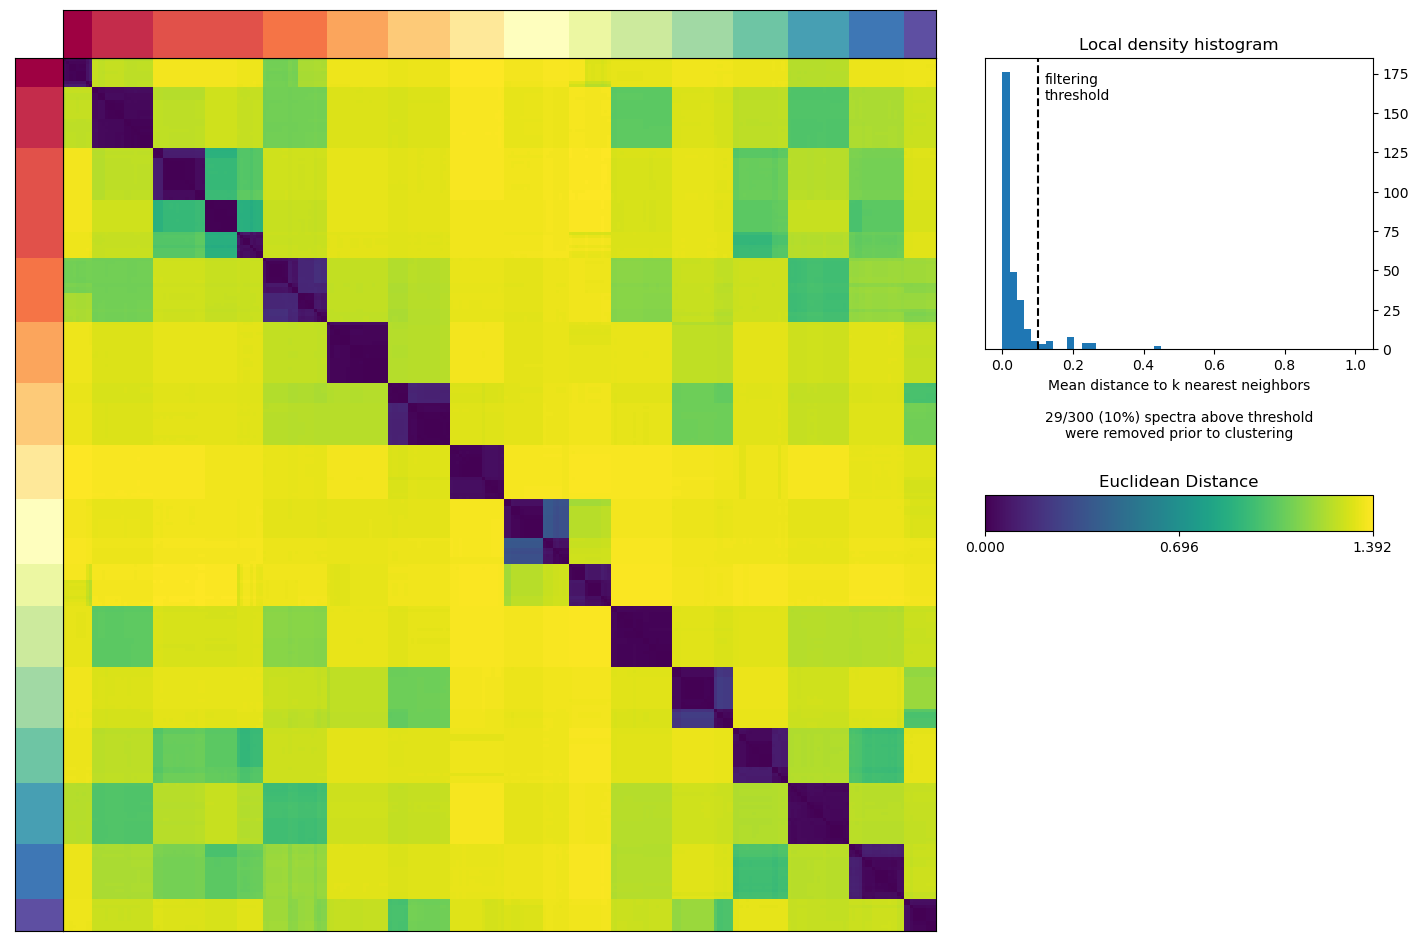

In [7]:
cnmf_obj = cNMF(output_dir='./example_islets', name='NoBatchCorrection')
cnmf_obj.prepare(counts_fn='./example_islets/filtered_raw_data.h5ad', components=[15], n_iter=20, seed=14, num_highvar_genes=2000)
cnmf_obj.factorize(worker_i=0, total_workers=1)
cnmf_obj.combine()
cnmf_obj.consensus(k=15, density_threshold=0.1, show_clustering=True, close_clustergram_fig=False)

In [8]:
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=15, density_threshold=0.1)
usage.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
human1_lib1.final_cell_0001,0.004792,0.024355,0.000000,0.710895,0.015311,0.000000,0.223913,0.007669,0.0,0.001033,0.004552,0.0,0.00000,0.0,0.007481
human1_lib1.final_cell_0002,0.026229,0.006873,0.000000,0.546607,0.049052,0.013523,0.346735,0.000000,0.0,0.000946,0.004442,0.0,0.00000,0.0,0.005595
human1_lib1.final_cell_0003,0.010435,0.000000,0.015103,0.855714,0.000000,0.000000,0.112450,0.000000,0.0,0.003532,0.001001,0.0,0.00133,0.0,0.000437
human1_lib1.final_cell_0004,0.003546,0.000000,0.000000,0.534609,0.001577,0.032281,0.416104,0.000000,0.0,0.006728,0.000000,0.0,0.00418,0.0,0.000975
human1_lib1.final_cell_0005,0.000000,0.069759,0.000000,0.585111,0.082706,0.032945,0.215502,0.007989,0.0,0.005094,0.000000,0.0,0.00000,0.0,0.000895


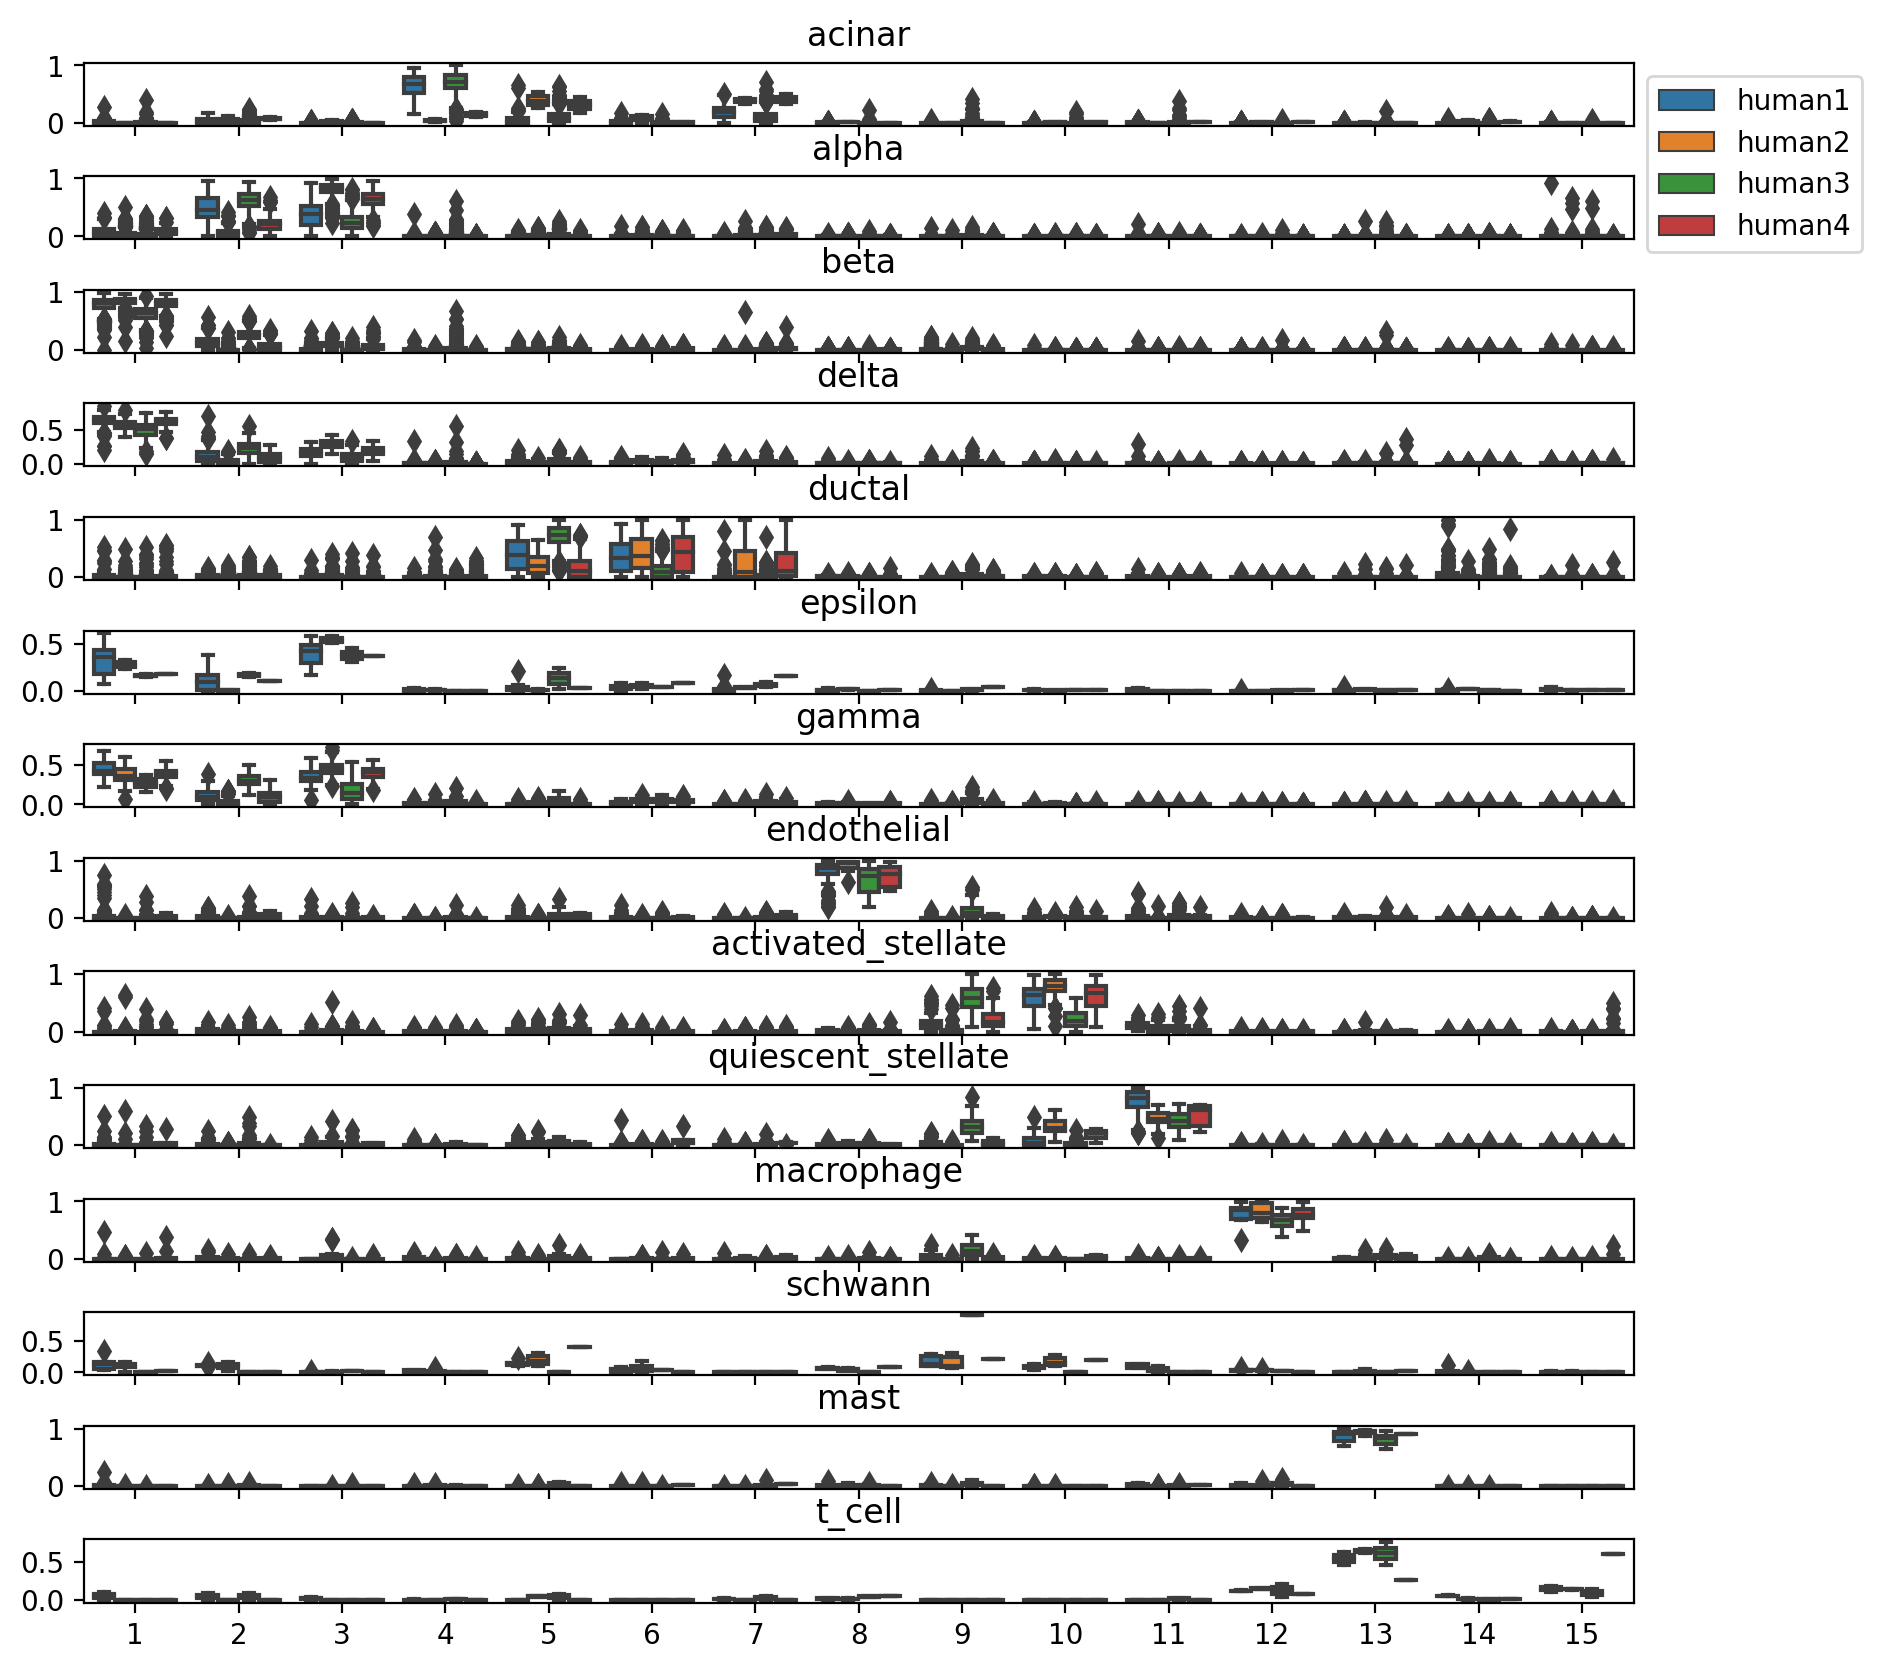

In [9]:
usage_norm_forplot = usage.unstack().reset_index()
usage_norm_forplot = pd.merge(left=usage_norm_forplot, right=adata.obs[['assigned_cluster', 'Sample']], left_on='level_1', right_index=True)
usage_norm_forplot.columns = ['GEP', 'cell', 'Usage', 'Cluster', 'Donor']

cluster_order = ['acinar', 'alpha', 'beta', 'delta', 'ductal','epsilon', 'gamma', 'endothelial', 'activated_stellate', 'quiescent_stellate',
                        'macrophage', 'schwann', 'mast', 't_cell']

(fig,axes) = plt.subplots(len(cluster_order),1, figsize=(10,10), dpi=200, gridspec_kw={'hspace':.8})
for i,k in enumerate(cluster_order):
    g = usage_norm_forplot.loc[usage_norm_forplot['Cluster'] == k, :]
    sns.boxplot(x='GEP', y='Usage', hue='Donor', ax=axes[i], data=g)
    axes[i].set_title(k)
    axes[i].legend(bbox_to_anchor=(1,1))
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    if i != (len(cluster_order)-1):
        axes[i].set_xticklabels([])
        
    if i != 0:
        axes[i].legend().remove()
    else:
        axes[i].legend(bbox_to_anchor=(1,1))
    

## As you can see from this plot of GEP usage stratified by published cluster and by donor or origin, there are some batch effected programs. For example, GEP 4 corresponds to acinar cells in samples 1 and 3, whereas GEP 5 corresponds to acinar cells in samples 2 and 4. Similarly, GEP 2 corresponds to alpha cells in samples 1 and 3 and GEP 4 corresponds to alpha cells in sample 2 and 4. This seems like a batch effect.

## Lets see if running batch correction prior to cNMF can improve this situation

# Batch effect correction

/Users/hannah/opt/anaconda3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


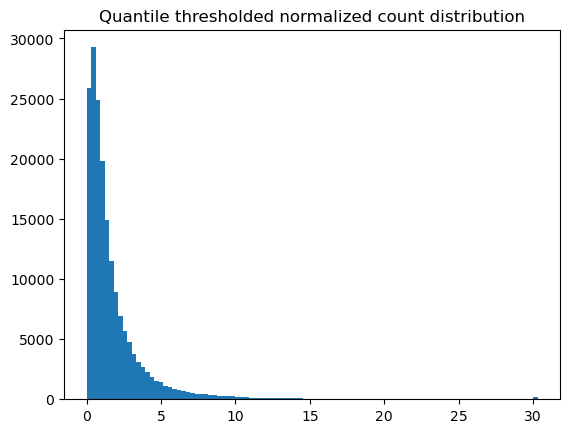

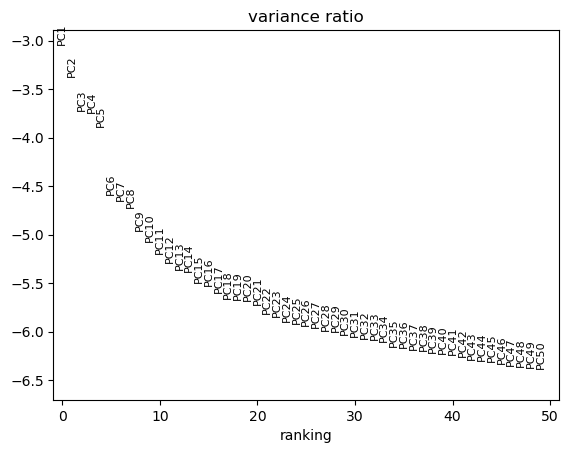

2023-08-30 16:50:48,744 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-08-30 16:50:50,694 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-08-30 16:50:50,726 - harmonypy - INFO - Iteration 1 of 20
2023-08-30 16:50:52,227 - harmonypy - INFO - Iteration 2 of 20
2023-08-30 16:50:53,738 - harmonypy - INFO - Iteration 3 of 20
2023-08-30 16:50:55,196 - harmonypy - INFO - Iteration 4 of 20
2023-08-30 16:50:56,558 - harmonypy - INFO - Iteration 5 of 20
2023-08-30 16:50:57,834 - harmonypy - INFO - Iteration 6 of 20
2023-08-30 16:50:59,100 - harmonypy - INFO - Converged after 6 iterations


Only considering the two last: ['.Varnorm', '.h5ad'].
Only considering the two last: ['.Varnorm', '.h5ad'].


In [10]:
p = Preprocess(random_seed=14)
(adata_c, adata_tp10k, hvgs) = p.preprocess_for_cnmf(adata, harmony_vars='Sample', n_top_rna_genes = 2000,
                                                     max_scaled_thresh = None, quantile_thresh = .9999, makeplots=True,
                                                    save_output_base='./example_islets/batchcorrect_example')

## The corrected data contains only the high-variance genes whereas the TP10K data contains all genes, and the hvgs output is just a list of the highvariance genes. If you specified the save_output_base output, these get saved to the files:

 - [save_output_base].Corrected.HVG.Varnorm.h5ad
 - [save_output_base].TP10K.h5ad
 - [save_output_base].Corrected.HVGs.txt

In [11]:
adata_c

AnnData object with n_obs × n_vars = 8569 × 2000
    obs: 'barcode', 'assigned_cluster', 'Sample', 'n_counts', 'Sex'
    var: 'gene_name', 'n_cells', 'features_renamed', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'X_pca', 'X_pca_harmony'

In [12]:
hvgs[:5]

['A2M', 'AADAC', 'AADACP1', 'ABCA4', 'ABCA8']

In [13]:
adata_tp10k

AnnData object with n_obs × n_vars = 8569 × 15117
    obs: 'barcode', 'assigned_cluster', 'Sample', 'n_counts', 'Sex'
    var: 'gene_name', 'n_cells', 'features_renamed'

## We then use these output files as the inputs for the cNMF prepare step

Only considering the two last: ['.Varnorm', '.h5ad'].
Only considering the two last: ['.Varnorm', '.h5ad'].


/Users/hannah/opt/anaconda3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
Combining factorizations for k=15.


/Users/hannah/opt/anaconda3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


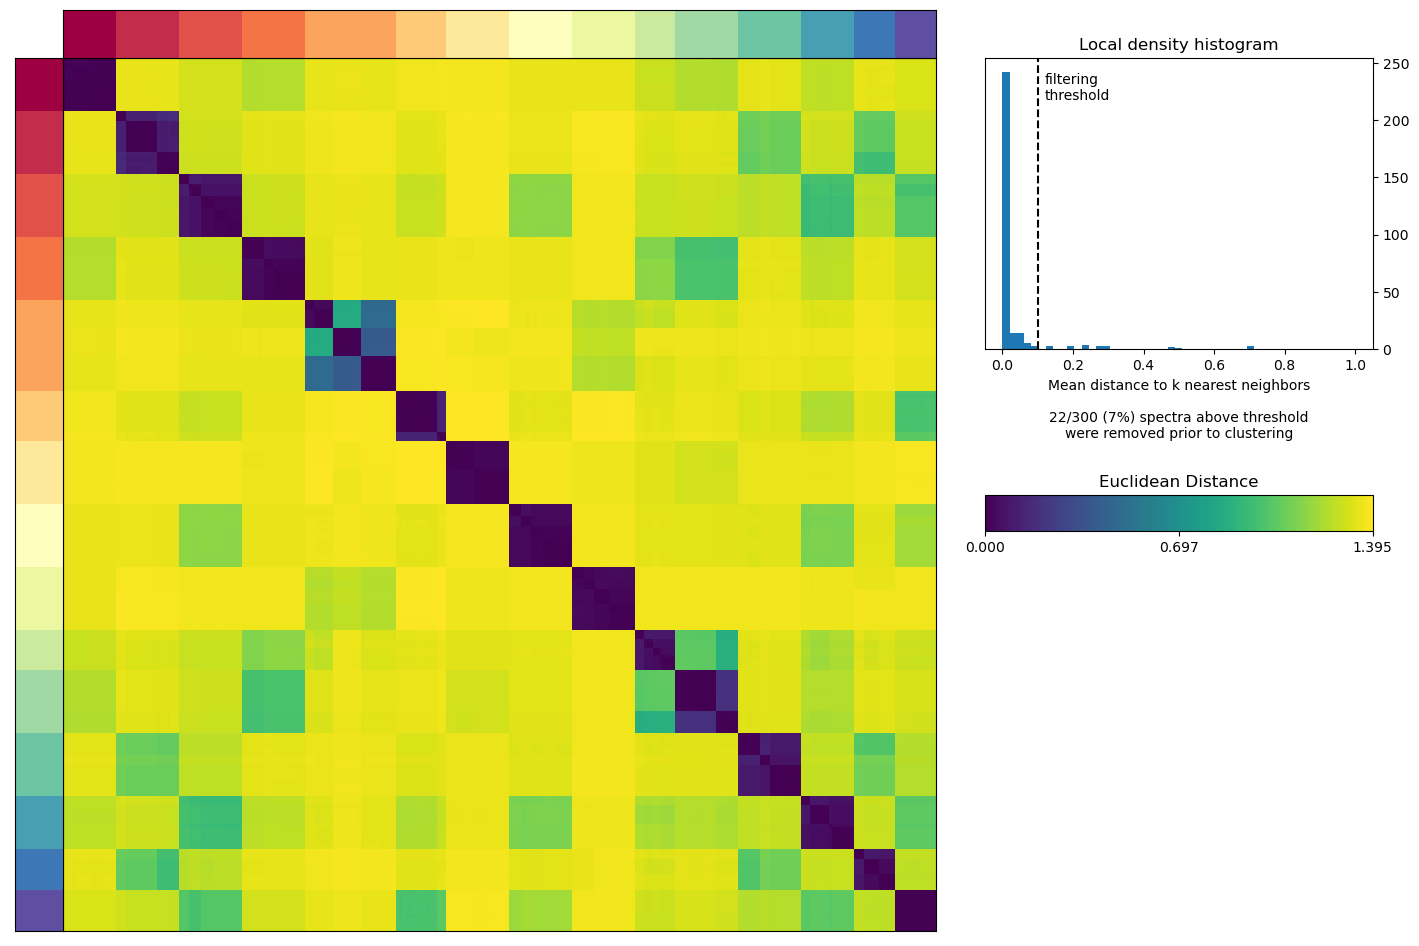

In [14]:
cnmf_obj_corrected = cNMF(output_dir='./example_islets', name='BatchCorrected')
cnmf_obj_corrected.prepare(counts_fn='./example_islets/batchcorrect_example.Corrected.HVG.Varnorm.h5ad',
                           tpm_fn='./example_islets/batchcorrect_example.TP10K.h5ad',
                           genes_file='./example_islets/batchcorrect_example.Corrected.HVGs.txt',
                           components=[15], n_iter=20, seed=14, num_highvar_genes=2000)
cnmf_obj_corrected.factorize(worker_i=0, total_workers=1)
cnmf_obj_corrected.combine()
cnmf_obj_corrected.consensus(k=15, density_threshold=0.1, show_clustering=True, close_clustergram_fig=False)

In [15]:
(usage_bc, spectra_scores_bc, spectra_tpm_bc, top_genes_bc) = cnmf_obj_corrected.load_results(K=15, density_threshold=0.1)
usage_bc.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
human1_lib1.final_cell_0001,0.011057,0.000000,0.613794,0.017072,0.017150,0.011244,0.314838,0.006325,0.003191,0.0,0.0,0.0,0.0,0.000000,0.005330
human1_lib1.final_cell_0002,0.009921,0.000000,0.857353,0.000000,0.013301,0.066161,0.048186,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.005078
human1_lib1.final_cell_0003,0.000000,0.000000,0.642538,0.000779,0.000000,0.000000,0.354463,0.000000,0.002220,0.0,0.0,0.0,0.0,0.000000,0.000000
human1_lib1.final_cell_0004,0.020410,0.000000,0.835789,0.002176,0.000000,0.069116,0.067945,0.000000,0.000000,0.0,0.0,0.0,0.0,0.004565,0.000000
human1_lib1.final_cell_0005,0.000000,0.004178,0.679262,0.005314,0.123306,0.017541,0.165660,0.004103,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000637


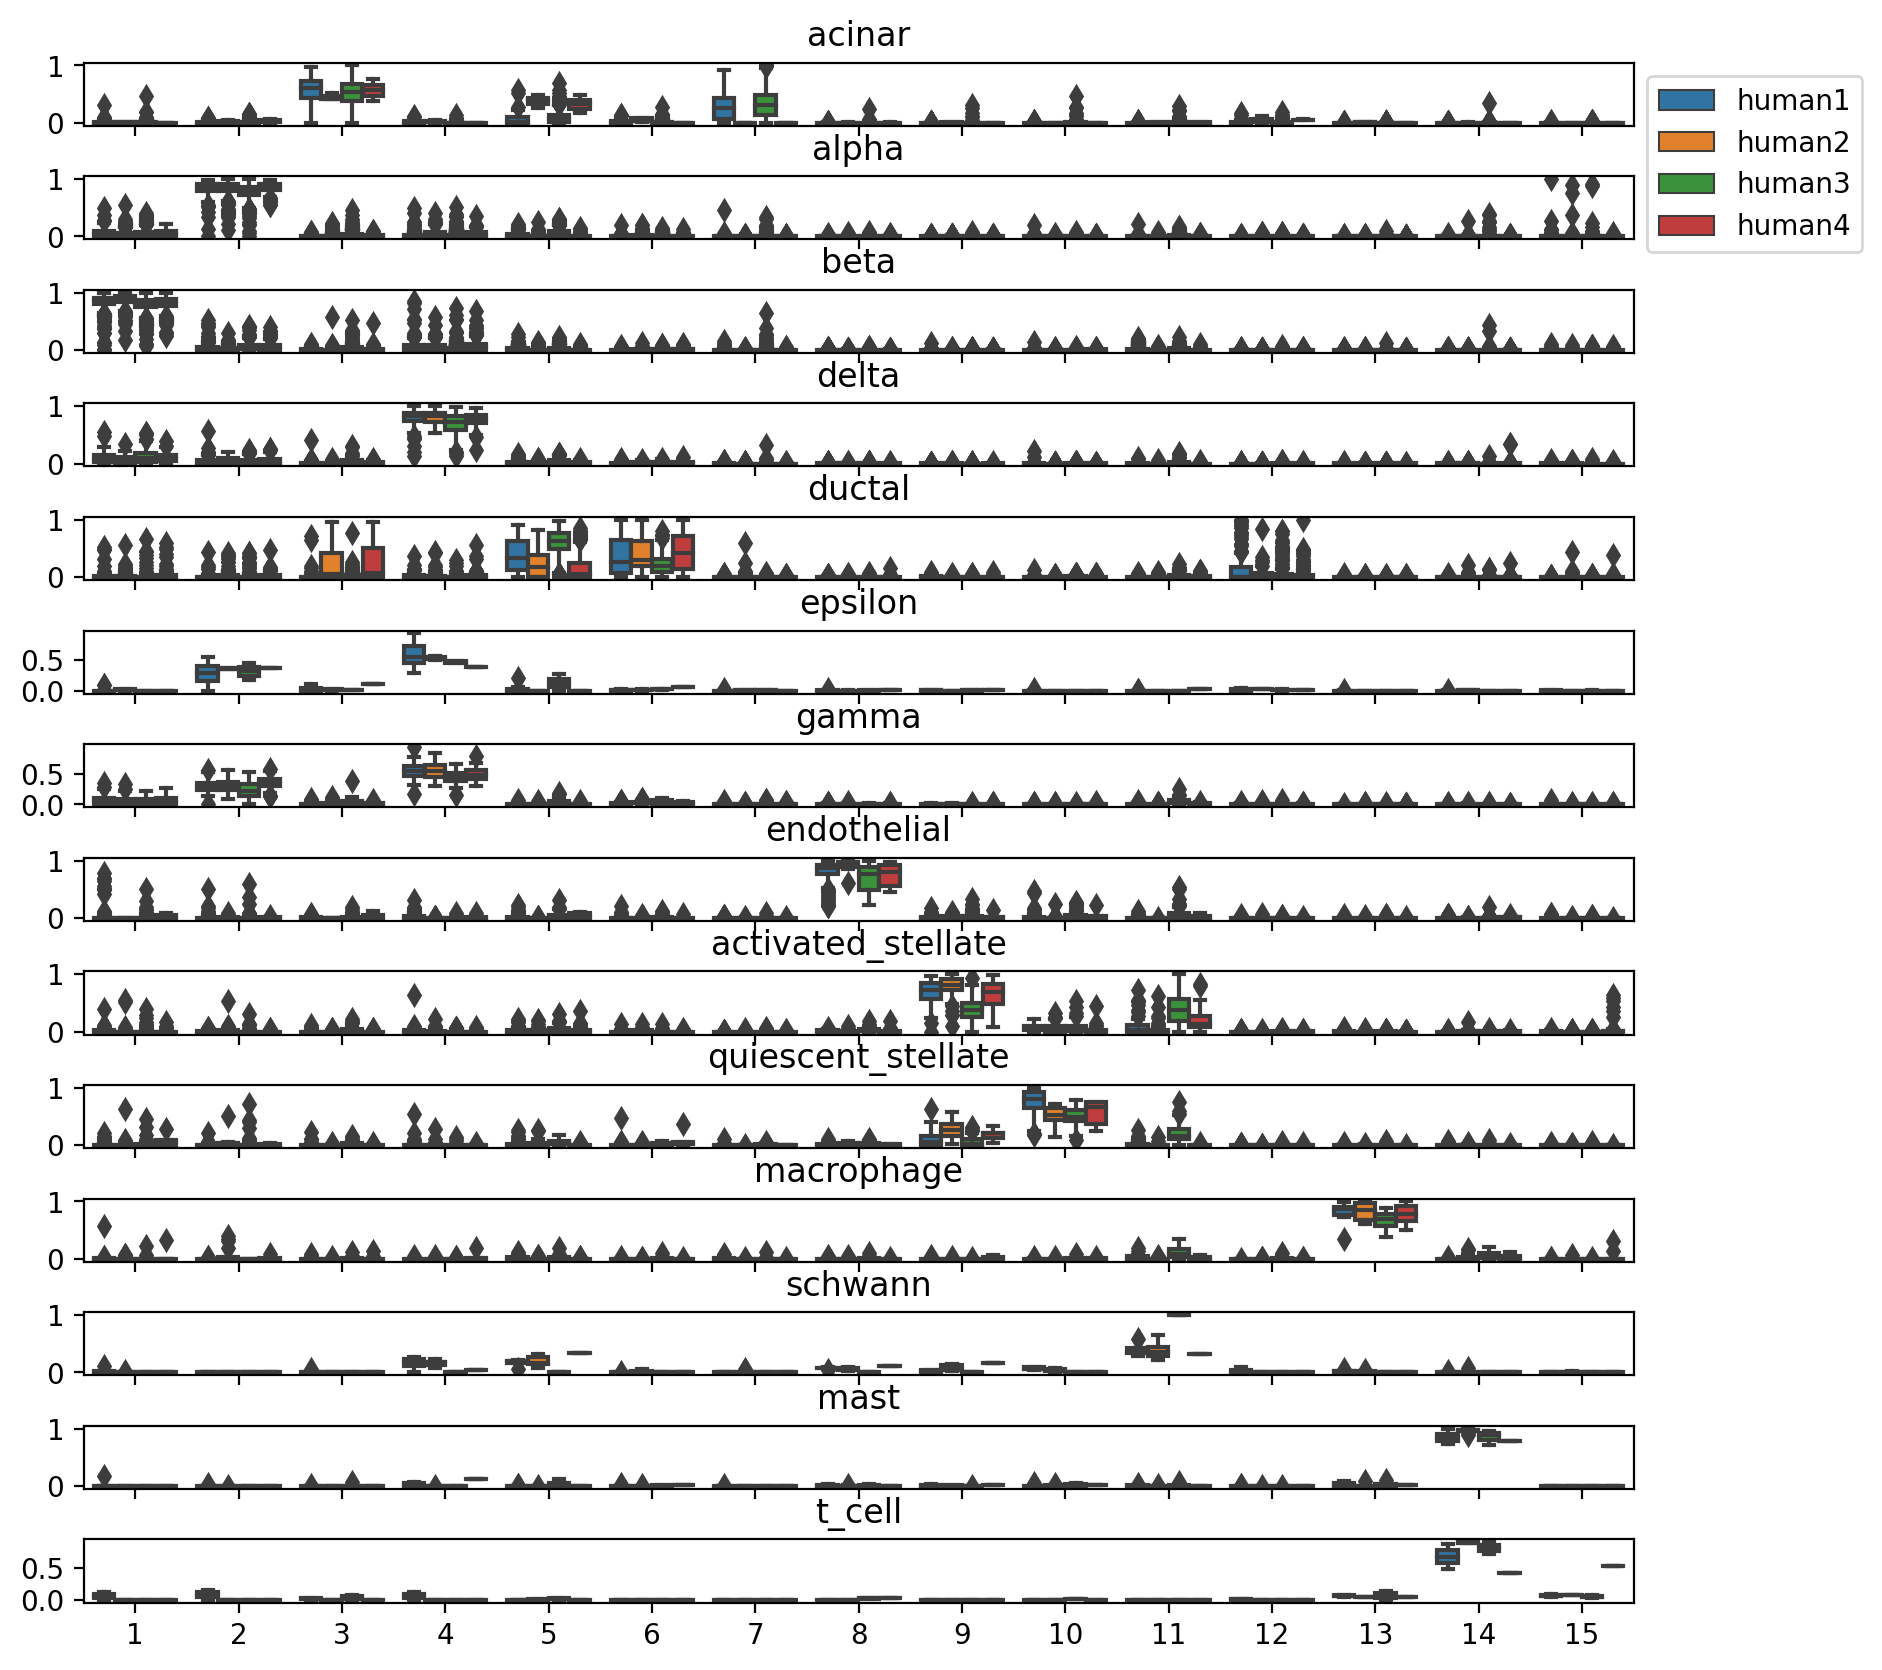

In [16]:
usage_norm_forplot = usage_bc.unstack().reset_index()
usage_norm_forplot = pd.merge(left=usage_norm_forplot, right=adata.obs[['assigned_cluster', 'Sample']], left_on='level_1', right_index=True)
usage_norm_forplot.columns = ['GEP', 'cell', 'Usage', 'Cluster', 'Donor']

cluster_order = ['acinar', 'alpha', 'beta', 'delta', 'ductal','epsilon', 'gamma', 'endothelial', 'activated_stellate', 'quiescent_stellate',
                        'macrophage', 'schwann', 'mast', 't_cell']

(fig,axes) = plt.subplots(len(cluster_order),1, figsize=(10,10), dpi=200, gridspec_kw={'hspace':.8})
for i,k in enumerate(cluster_order):
    g = usage_norm_forplot.loc[usage_norm_forplot['Cluster'] == k, :]
    sns.boxplot(x='GEP', y='Usage', hue='Donor', ax=axes[i], data=g)
    axes[i].set_title(k)
    axes[i].legend(bbox_to_anchor=(1,1))
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    if i != (len(cluster_order)-1):
        axes[i].set_xticklabels([])
        
    if i != 0:
        axes[i].legend().remove()
    else:
        axes[i].legend(bbox_to_anchor=(1,1))
    

## Now there is a single GEP for alpha cells (2) and a primar GEP for acinar cells (3) and beta and delta cells are better discriminated (GEP 1 vs. GEP 4). There is still some batch correlated signal, most notably in GEP 5 and 8. Some of this might reflect true biology as  donors 1 and 3 were male and donors 2 and 4 were female.

## Lets see if including sex as a covariate to remove reduces this signal as well'

/Users/hannah/opt/anaconda3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


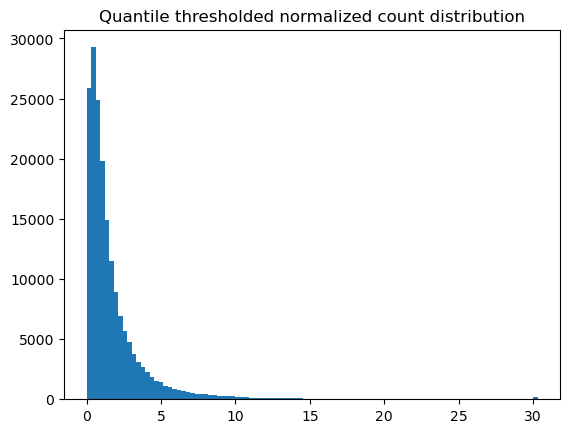

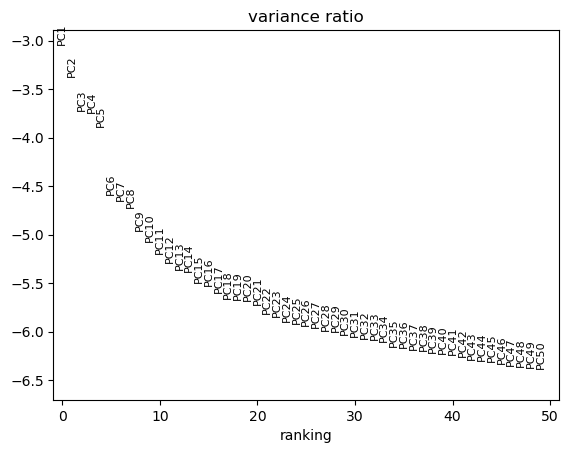

2023-08-30 16:52:33,742 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-08-30 16:52:35,684 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-08-30 16:52:35,712 - harmonypy - INFO - Iteration 1 of 20
2023-08-30 16:52:37,005 - harmonypy - INFO - Iteration 2 of 20
2023-08-30 16:52:38,429 - harmonypy - INFO - Iteration 3 of 20
2023-08-30 16:52:40,055 - harmonypy - INFO - Iteration 4 of 20
2023-08-30 16:52:41,393 - harmonypy - INFO - Iteration 5 of 20
2023-08-30 16:52:42,598 - harmonypy - INFO - Iteration 6 of 20
2023-08-30 16:52:43,776 - harmonypy - INFO - Converged after 6 iterations


Only considering the two last: ['.Varnorm', '.h5ad'].
Only considering the two last: ['.Varnorm', '.h5ad'].


In [17]:
p = Preprocess(random_seed=14)
(adata_c, adata_tp10k, hvgs) = p.preprocess_for_cnmf(adata, harmony_vars=['Sex', 'Sample'], n_top_rna_genes = 2000,
                                                     max_scaled_thresh = None, quantile_thresh = .9999, makeplots=True,
                                                    save_output_base='./example_islets/batchcorrect_example_sex')

Only considering the two last: ['.Varnorm', '.h5ad'].
Only considering the two last: ['.Varnorm', '.h5ad'].


/Users/hannah/opt/anaconda3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
Combining factorizations for k=15.


/Users/hannah/opt/anaconda3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


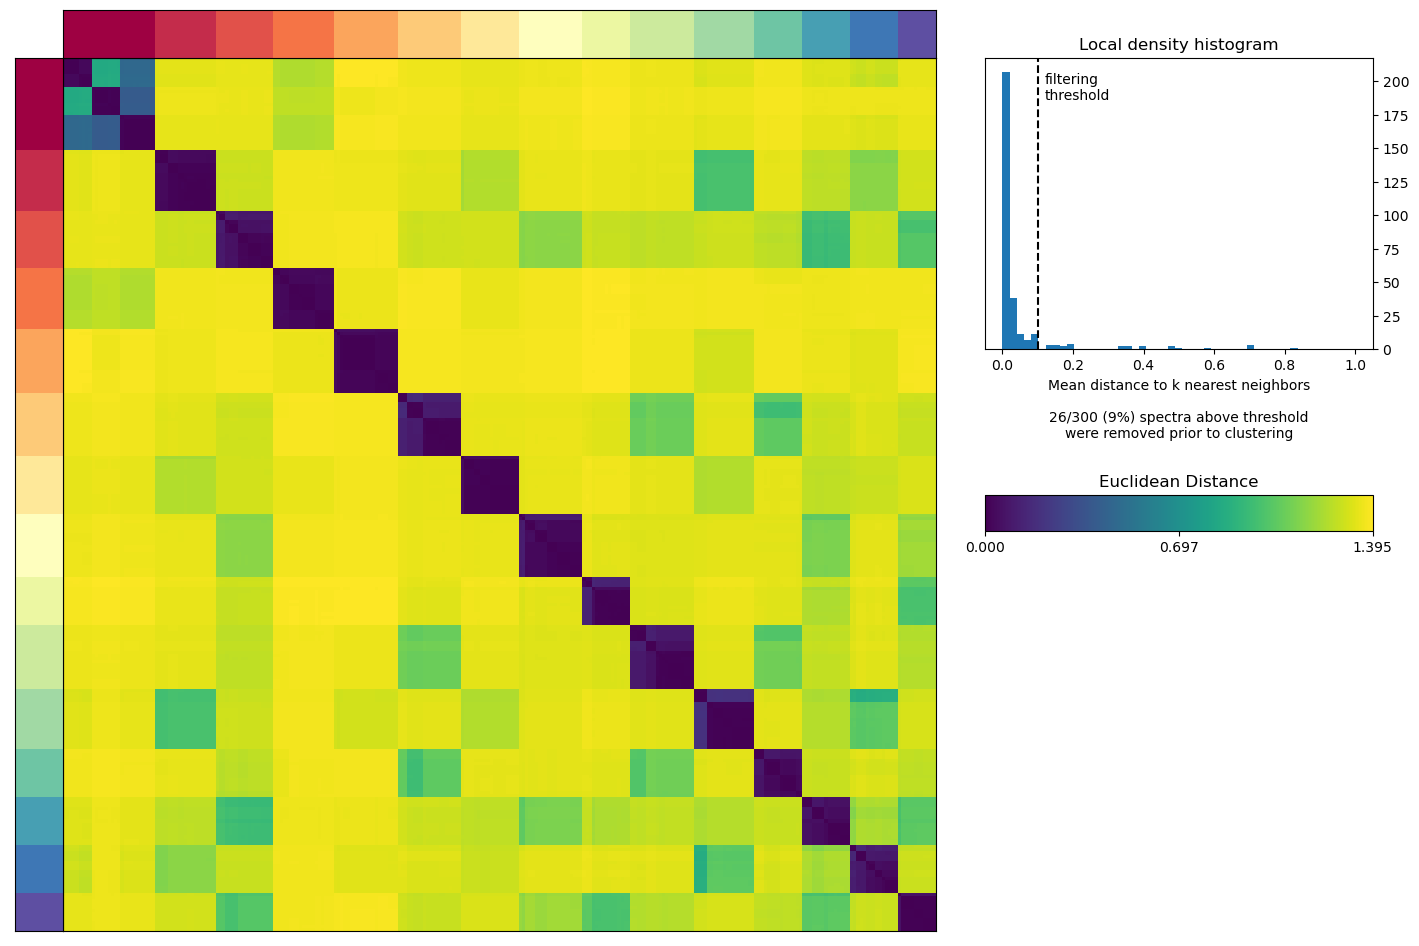

In [18]:
cnmf_obj_corrected = cNMF(output_dir='./example_islets', name='BatchCorrected_SexAndSample')
cnmf_obj_corrected.prepare(counts_fn='./example_islets/batchcorrect_example_sex.Corrected.HVG.Varnorm.h5ad',
                           tpm_fn='./example_islets/batchcorrect_example_sex.TP10K.h5ad',
                           genes_file='./example_islets/batchcorrect_example_sex.Corrected.HVGs.txt',
                           components=[15], n_iter=20, seed=14, num_highvar_genes=2000)
cnmf_obj_corrected.factorize(worker_i=0, total_workers=1)
cnmf_obj_corrected.combine()
cnmf_obj_corrected.consensus(k=15, density_threshold=0.1, show_clustering=True, close_clustergram_fig=False)

In [19]:
(usage_sex, spectra_scores_sex, spectra_tpm_sex, top_genes_sex) = cnmf_obj_corrected.load_results(K=15, density_threshold=0.1)
usage_sex.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
human1_lib1.final_cell_0001,0.009634,0.000000,0.642730,0.016451,0.013940,0.009961,0.292878,0.006323,0.002740,0.0,0.0,0.0,0.0,0.000000,0.005343
human1_lib1.final_cell_0002,0.010423,0.000000,0.886197,0.000000,0.011994,0.067873,0.018475,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.005037
human1_lib1.final_cell_0003,0.000000,0.000000,0.673010,0.000000,0.000000,0.000000,0.325637,0.000000,0.001353,0.0,0.0,0.0,0.0,0.000000,0.000000
human1_lib1.final_cell_0004,0.021008,0.000000,0.844951,0.003197,0.000000,0.072423,0.053682,0.000000,0.000000,0.0,0.0,0.0,0.0,0.004739,0.000000
human1_lib1.final_cell_0005,0.000000,0.003681,0.702448,0.005266,0.121655,0.017813,0.144397,0.004050,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000689


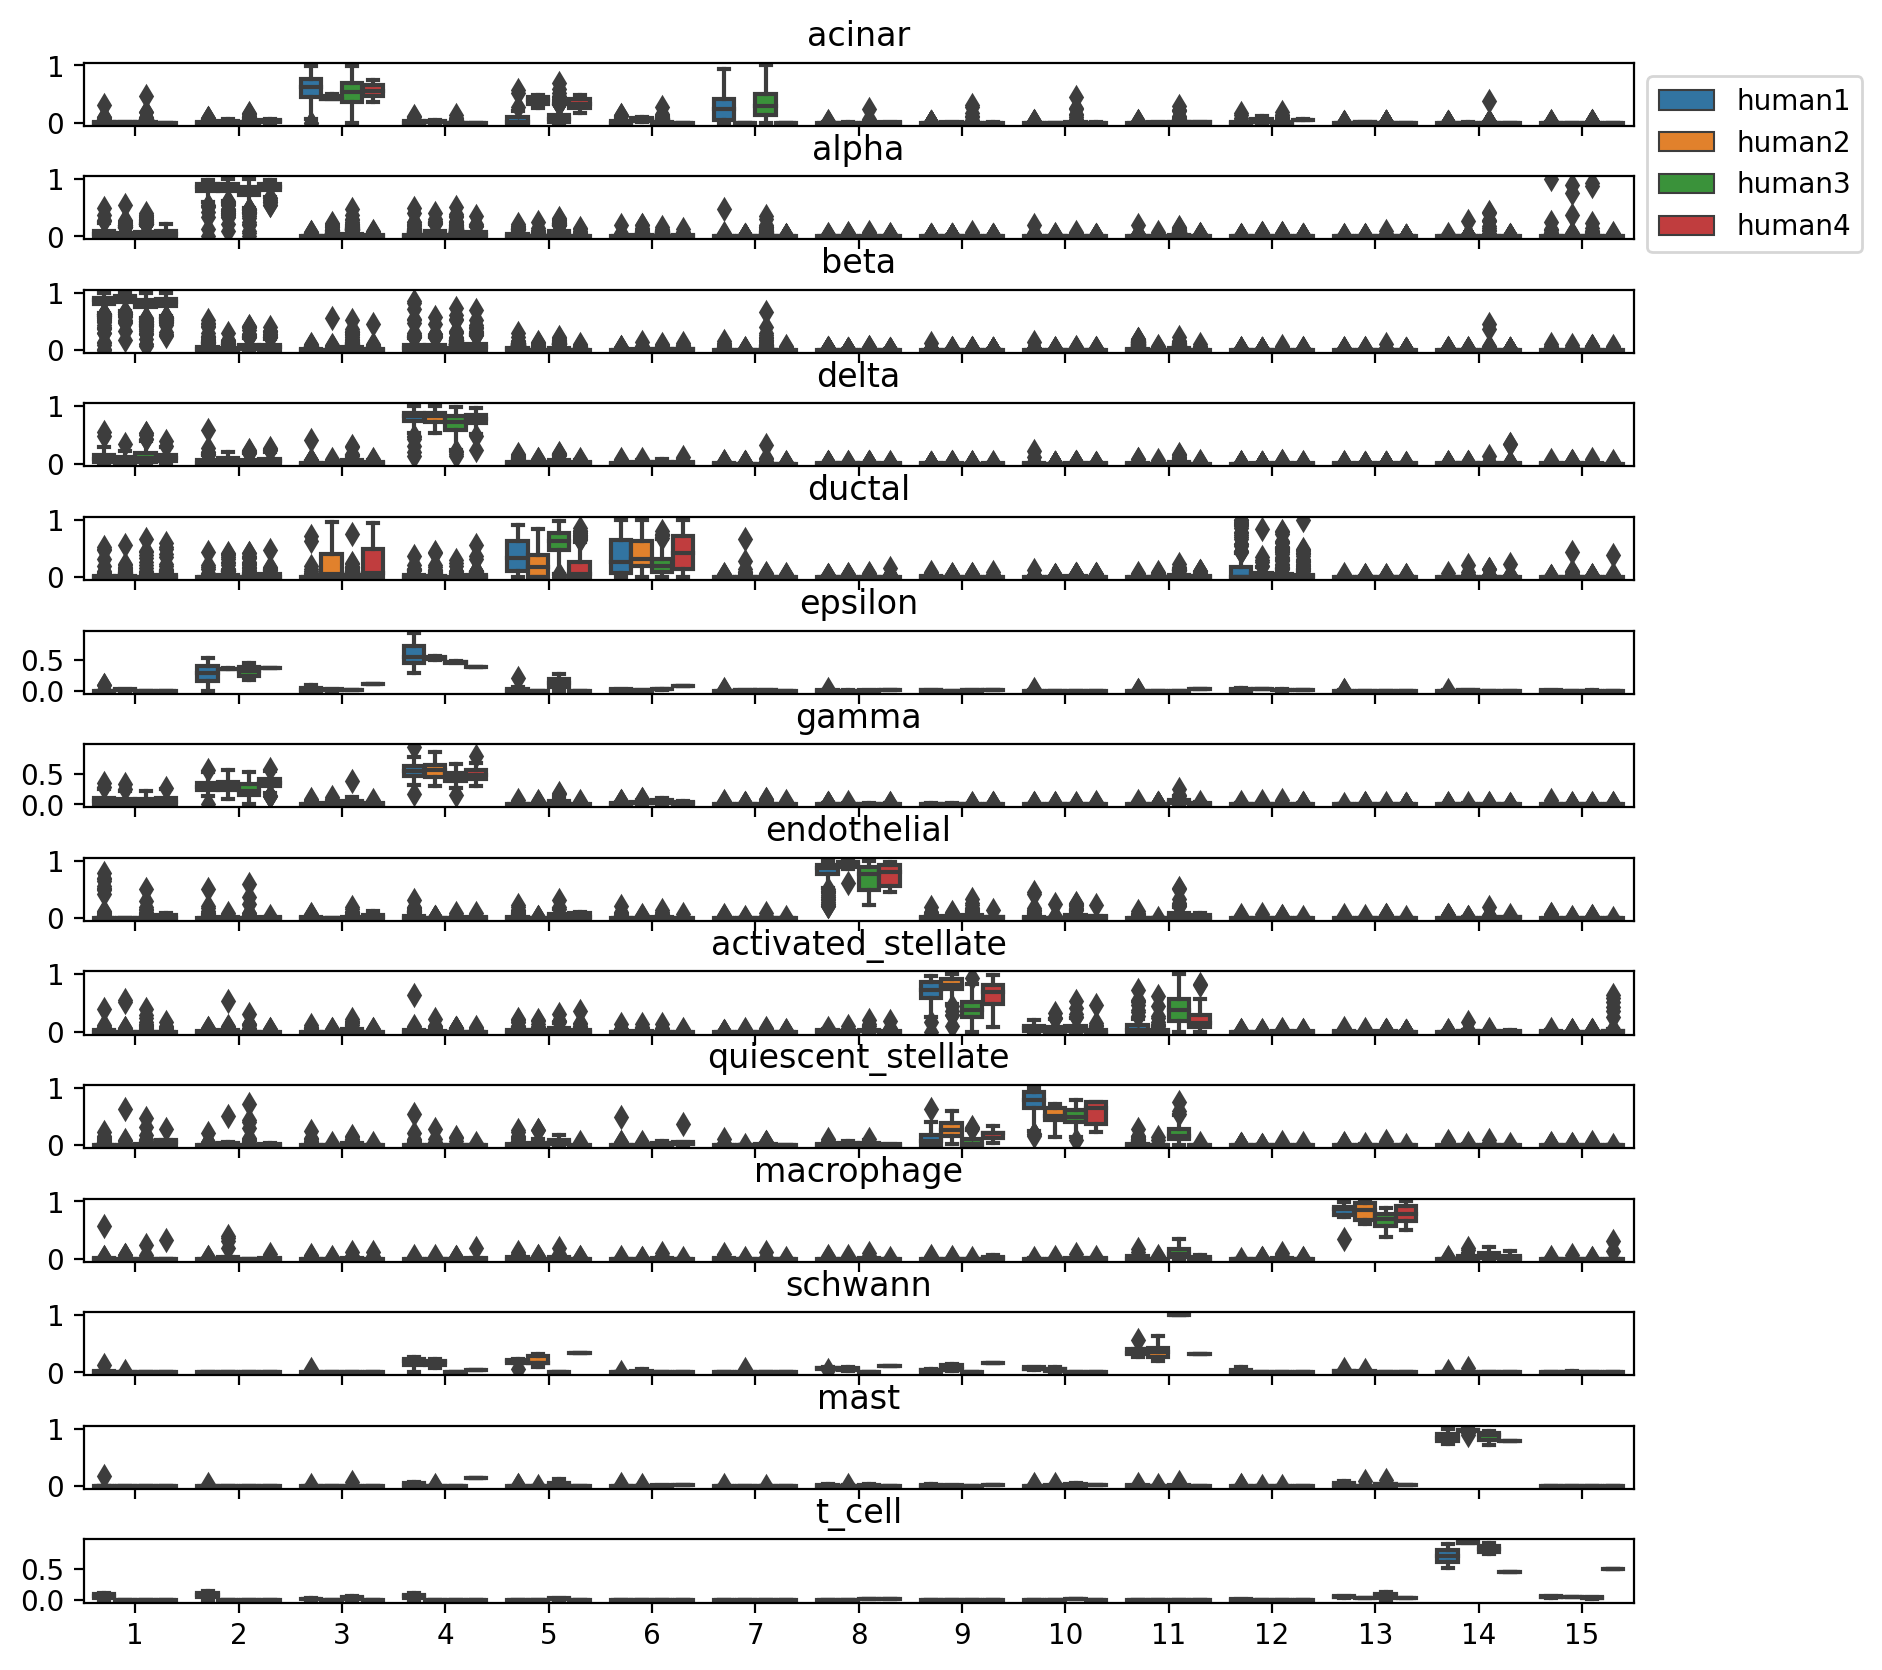

In [20]:
usage_norm_forplot = usage_sex.unstack().reset_index()
usage_norm_forplot = pd.merge(left=usage_norm_forplot, right=adata.obs[['assigned_cluster', 'Sample']], left_on='level_1', right_index=True)
usage_norm_forplot.columns = ['GEP', 'cell', 'Usage', 'Cluster', 'Donor']

cluster_order = ['acinar', 'alpha', 'beta', 'delta', 'ductal','epsilon', 'gamma', 'endothelial', 'activated_stellate', 'quiescent_stellate',
                        'macrophage', 'schwann', 'mast', 't_cell']

(fig,axes) = plt.subplots(len(cluster_order),1, figsize=(10,10), dpi=200, gridspec_kw={'hspace':.8})
for i,k in enumerate(cluster_order):
    g = usage_norm_forplot.loc[usage_norm_forplot['Cluster'] == k, :]
    sns.boxplot(x='GEP', y='Usage', hue='Donor', ax=axes[i], data=g)
    axes[i].set_title(k)
    axes[i].legend(bbox_to_anchor=(1,1))
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    if i != (len(cluster_order)-1):
        axes[i].set_xticklabels([])
        
    if i != 0:
        axes[i].legend().remove()
    else:
        axes[i].legend(bbox_to_anchor=(1,1))